### Setup

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'
device

device(type='mps')

### Get data

In [4]:
image_path = 'pizza_steak_sushi'
train_dir = image_path  + '/train'
test_dir = image_path + '/test'
train_dir

'pizza_steak_sushi/train'

In [63]:
IMG_SIZE = 224
BATCH_SIZE = 32  # 32 is too big in the training
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x3894c4690>,
 ['pizza', 'steak', 'sushi'])

In [64]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [7]:
# visualize a image
# get a batch
image_batch, label_batch = next(iter(train_dataloader))
# first image
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

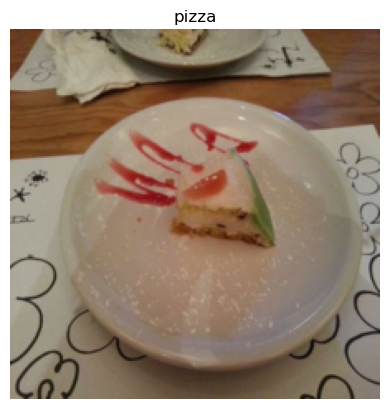

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

### Test on input and output shape

In [7]:
# Equation 1
# embedding layer test by example
# create example data
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the num of patches
number_of_patches = int((height * width) / patch_size ** 2)
print(number_of_patches)

196


In [9]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape # output: (N, P ** 2 x C)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'input shape : {embedding_layer_input_shape}')
print(f'output shape : {embedding_layer_output_shape}')
print('Every patch will become 1 dimension data')

input shape : (224, 224, 3)
output shape : (196, 768)
Every patch will become 1 dimension data


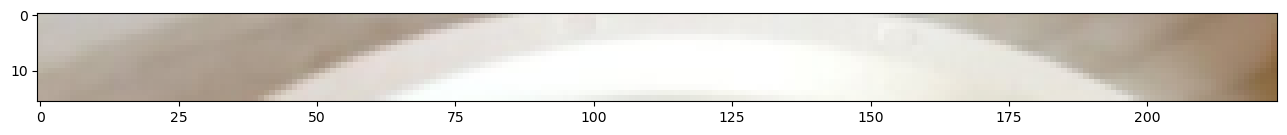

In [36]:
# use the image above in memory
# HWC
image_permuted = image.permute((1, 2, 0))
# plot the top row
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [37]:
# plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'img_size must be divisible by patch_size.'
print(f'Number of patches per row : {num_patches}')

Number of patches per row : 14.0


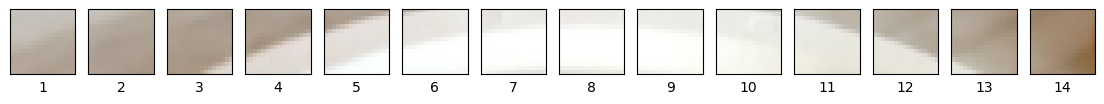

In [44]:
# create a series of subplots
fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True,
    sharey = True
)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [45]:
# plot full images into patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'img_size must be divisible by patch_size.'
print(f'Number of patches per row : {num_patches}')
print(f'Number of patches per col : {num_patches}')
print(f'Number of total patches : {num_patches * num_patches}')
print(f'Size of one patch : {patch_size} x {patch_size}')

Number of patches per row : 14.0
Number of patches per col : 14.0
Number of total patches : 196.0
Size of one patch : 16 x 16


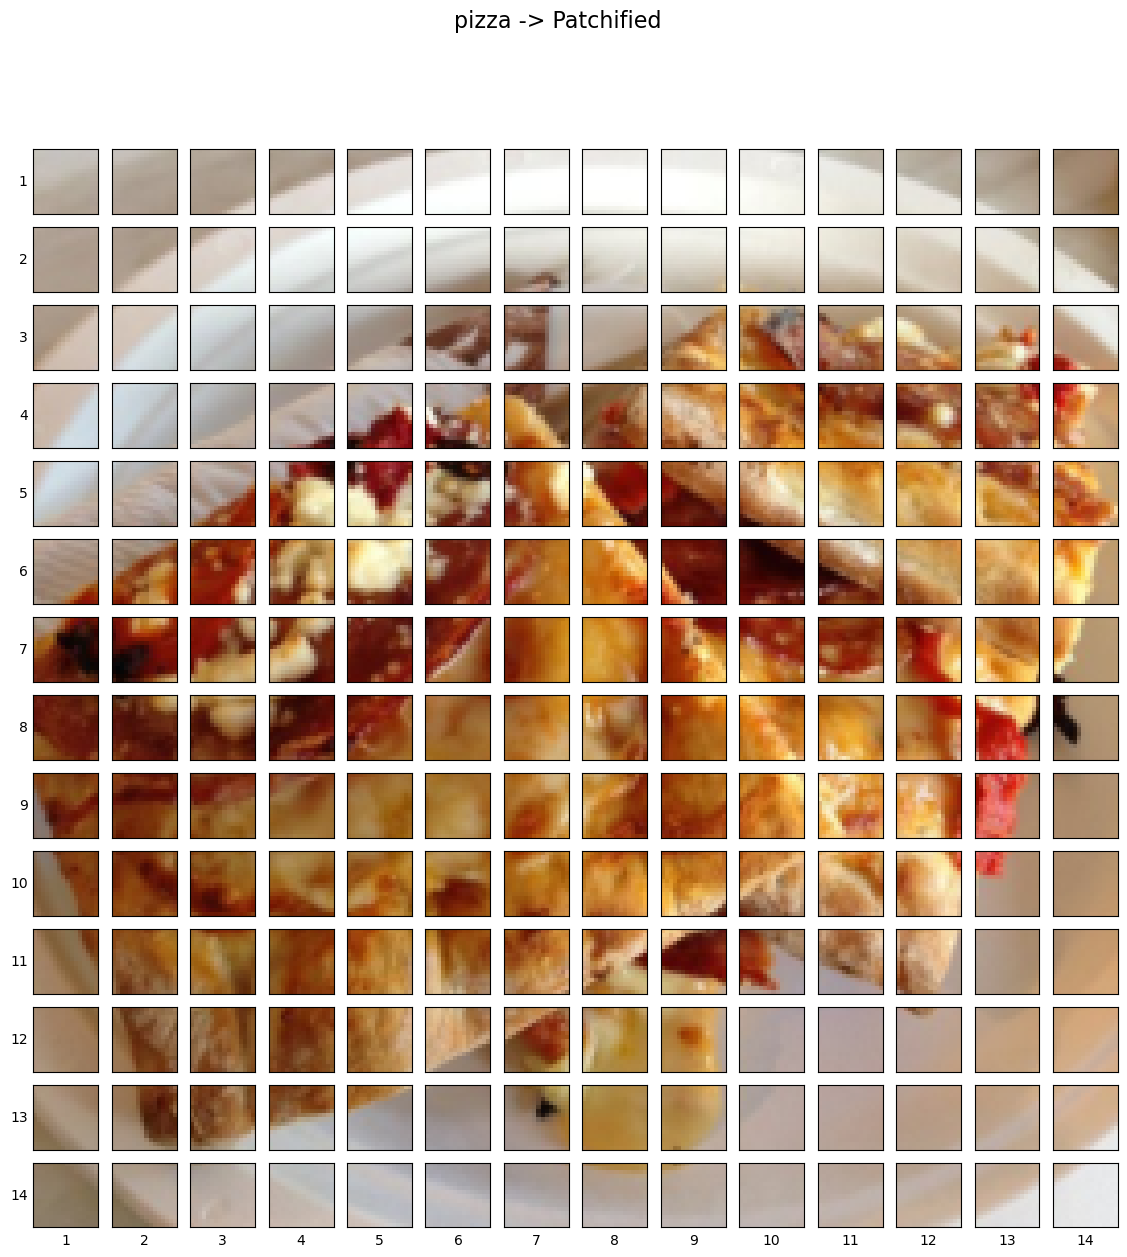

In [53]:
# create a series of subplots
fig, axs = plt.subplots(
    nrows = img_size // patch_size,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True,
    sharey = True
)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, 
                         patch_width:patch_width + patch_size, :])
        axs[i, j].set_ylabel(i + 1,
                            rotation='horizontal',
                            horizontalalignment='right',
                            verticalalignment='center')
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Create image patch embeddings with torch.nn.Conv2d()

In [54]:
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

In [65]:
image_through_conv = conv2d(image.unsqueeze(0))
print(f'The origin image shape: {image.shape}\n'
    f'Image after conv layer: {image_through_conv.shape}\n'
    f'every patch have {16 * 16 * 3} pixels.')

The origin image shape: torch.Size([3, 224, 224])
Image after conv layer: torch.Size([1, 768, 14, 14])
every patch have 768 pixels.


Showing random conv feature map from indexes: [5, 464, 103, 585, 517]


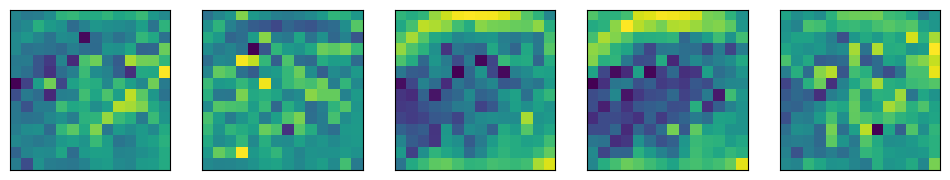

In [69]:
# plot 5 random feature maps from all of the 768 of them
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f'Showing random conv feature map from indexes: {random_indexes}')

# set up fig
fig, axs = plt.subplots(
    nrows = 1,
    ncols = 5,
    figsize = (12, 12)
)

# plot random image feature map
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_through_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [73]:
# check a single feature map
single_feature_map = image_through_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

### Flatten the patch embedding with torch.nn.Flatten()

In [74]:
print(f'current patch shape: {image_through_conv.shape} --> [batch, embed_dim, feature_map_height, feature_map_width]')

current patch shape: torch.Size([1, 768, 14, 14]) --> [batch, embed_dim, feature_map_height, feature_map_width]


In [76]:
# create a flatten layer
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_through_flatten = flatten(image_through_conv)

In [77]:
image_throuth_flatten_reshaped = image_through_flatten.permute(0, 2, 1)
print(f'after flatten layer shape: {image_throuth_flatten_reshaped.shape} --> [batch, num_patches, embed_dim]')

after flatten layer shape: torch.Size([1, 196, 768]) --> [batch, num_patches, embed_dim]


(-0.5, 195.5, 0.5, -0.5)

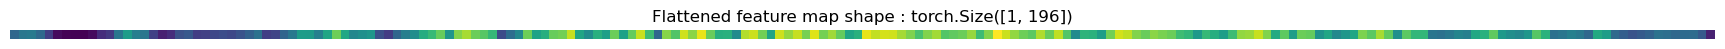

In [79]:
# check one single flattened feature map
single_flattened_feature_map = image_throuth_flatten_reshaped[:, :, 0]  # because one map means one dim
# plot the flattened map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape : {single_flattened_feature_map.shape}')
plt.axis(False)

In [80]:
# see the flattened featuren map as a tensor
single_flattened_feature_map.shape, single_flattened_feature_map.requires_grad

(torch.Size([1, 196]), True)

### Class: PatchEmbedding (conv + flatten)

In [9]:
# create a class subclass nn.Module
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels = in_channels,
            out_channels = embedding_dim,
            kernel_size = patch_size,
            stride = patch_size,
            padding = 0
        )

        self.flatten = nn.Flatten(
            start_dim = 2,
            end_dim = 3
        )

    def forward(self, x):
        # size check
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'Image size must be divisible by patch size'

        x_conv = self.conv(x)
        x_flatten = self.flatten(x_conv)

        return x_flatten.permute(0, 2, 1)

In [89]:
set_seeds()
patchify = PatchEmbedding()
print(f'Image shape before patch: {image.unsqueeze(0).shape} --> [batch, embed_dim, feature_map_height, feature_map_width]')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Image shape after patch: {patch_embedded_image.shape} --> [batch, num_patches, embed_dim]')

Image shape before patch: torch.Size([1, 3, 224, 224]) --> [batch, embed_dim, feature_map_height, feature_map_width]
Image shape after patch: torch.Size([1, 196, 768]) --> [batch, num_patches, embed_dim]


### Add class token embedding on the 'num_patches'(feature map) the 2nd dimension

In [106]:
batch_size, num_patches, embedding_dimension = patch_embedded_image.shape[0], patch_embedded_image.shape[1], patch_embedded_image.shape[-1]
batch_size, num_patches, embedding_dimension

(1, 196, 768)

In [94]:
# create the class token embedding as a learnable parameter
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad = True
)
patch_embedded_image.shape, class_token.shape

(torch.Size([1, 196, 768]), torch.Size([1, 1, 768]))

In [97]:
# concat the class token with patch embedding on 1st dimension
patch_embedded_with_class_token_on_top = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_with_class_token_on_top.shape

torch.Size([1, 197, 768])

In [99]:
patch_embedded_with_class_token_on_top

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.7481,  0.1859, -0.1381,  ...,  0.5316, -0.3860,  0.2697],
         [-0.6533,  0.1381, -0.1571,  ...,  0.5152, -0.3619,  0.2495],
         ...,
         [-0.7874,  0.1871, -0.1867,  ...,  0.5284, -0.3229,  0.2675],
         [-0.7677,  0.2318, -0.3890,  ...,  0.6401, -0.2843,  0.2697],
         [-1.0034,  0.3206, -0.2779,  ...,  0.7036, -0.3728,  0.3157]]],
       grad_fn=<CatBackward0>)

### Add position embedding

In [103]:
# create the learnable 1d position embedding
position_embedding = nn.Parameter(
    torch.ones(batch_size, num_patches + 1, embedding_dimension),
    requires_grad = True
)
position_embedding.shape

torch.Size([1, 197, 768])

In [104]:
patch_class_position_embedding = patch_embedded_with_class_token_on_top + position_embedding
patch_class_position_embedding.shape

torch.Size([1, 197, 768])

In [105]:
patch_class_position_embedding

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.2519,  1.1859,  0.8619,  ...,  1.5316,  0.6140,  1.2697],
         [ 0.3467,  1.1381,  0.8429,  ...,  1.5152,  0.6381,  1.2495],
         ...,
         [ 0.2126,  1.1871,  0.8133,  ...,  1.5284,  0.6771,  1.2675],
         [ 0.2323,  1.2318,  0.6110,  ...,  1.6401,  0.7157,  1.2697],
         [-0.0034,  1.3206,  0.7221,  ...,  1.7036,  0.6272,  1.3157]]],
       grad_fn=<AddBackward0>)

### Equation 1: patch + class token + position

x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

In [13]:
set_seeds()
patch_size = 16
x = image.unsqueeze(0)
print(f'image shape : {x.shape}')

patchify = PatchEmbedding()
patch_embedding = patchify(x)
print(f'patch_embedding shape : {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
num_patches = patch_embedding.shape[1]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad = True
)
patch_class_embedding = torch.cat((class_token, patch_embedding), dim=1)
print(f'patch_class_embedding shape : {patch_class_embedding.shape}')

position_embedding = nn.Parameter(
    torch.ones(batch_size, num_patches + 1, embedding_dimension),
    requires_grad = True
)
patch_class_position_embedding = patch_class_embedding + position_embedding
print(f'patch_class_position_embedding shape : {patch_class_position_embedding.shape}')

image shape : torch.Size([1, 3, 224, 224])
patch_embedding shape : torch.Size([1, 196, 768])
patch_class_embedding shape : torch.Size([1, 197, 768])
patch_class_position_embedding shape : torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input(residual haven't been added)

In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int = 768,
        num_heads:int = 12,
        attn_dropout:float = 0
    ):
        super().__init__()
        # create the norm layer on embedding dimension
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        # create the MSA layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim = embedding_dim,
            num_heads = num_heads,
            dropout = attn_dropout,
            batch_first = True  # (batch, seq, feature)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query = x,
            key = x,
            value = x,
            need_weights = False
        )
        return attn_output

In [15]:
# create an instance of msa block
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim = 768,
    num_heads = 12
)

image_through_msa = multihead_self_attention_block(patch_class_position_embedding)
print(f'patch_class_position_embedding shape : {patch_class_position_embedding.shape}')
print(f'image_through_msa shape : {image_through_msa.shape}')

patch_class_position_embedding shape : torch.Size([1, 197, 768])
image_through_msa shape : torch.Size([1, 197, 768])


In [16]:
patch_class_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5373, 1.0406, 0.9245,  ..., 1.2322, 0.8806, 1.1808],
         [0.2678, 1.1793, 0.7973,  ..., 1.4845, 0.8208, 1.2178],
         ...,
         [0.5138, 0.9811, 1.0287,  ..., 1.2724, 0.8049, 1.2769],
         [0.6146, 1.1527, 0.7698,  ..., 1.3121, 0.8305, 1.1828],
         [0.5424, 1.1076, 0.8264,  ..., 1.3590, 0.7687, 1.1783]]],
       grad_fn=<AddBackward0>)

In [17]:
image_through_msa

tensor([[[-0.2449, -0.2332,  0.0724,  ..., -0.4573,  0.9246, -0.4918],
         [-0.2403, -0.2267,  0.0769,  ..., -0.4569,  0.9347, -0.4994],
         [-0.2392, -0.2257,  0.0772,  ..., -0.4571,  0.9350, -0.5008],
         ...,
         [-0.2385, -0.2272,  0.0745,  ..., -0.4603,  0.9355, -0.5020],
         [-0.2385, -0.2264,  0.0761,  ..., -0.4566,  0.9340, -0.5018],
         [-0.2406, -0.2259,  0.0764,  ..., -0.4574,  0.9349, -0.5010]]],
       grad_fn=<TransposeBackward0>)

### Equation 3: Multilayer Percaptron (MLP)
layernorm -> linearlayer -> non-linearlayer -> dropout -> linearlayer -> dropout

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block(residual haven't been added)

In [19]:
class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int = 768,
        mlp_size:int = 3072,  # MLP size from table1 for ViT-base
        dropout:float = 0.1  # Dropout from table3 for ViT-base
    ):
        super().__init__()
        # create the Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        # create the Multilayer perceptron layers
        self.mlp = nn.Sequential(
            nn.Linear(
                in_features = embedding_dim,
                out_features = mlp_size
            ),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(
                in_features = mlp_size,
                out_features = embedding_dim
            ),
            nn.Dropout(p = dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        # return self.mlp(self.layer_norm(x)) is same as above but fast

In [20]:
# create an instance of MLPblock
mlp_block = MLPBlock(
    embedding_dim = 768,
    mlp_size = 3072,
    dropout = 0.1
)

image_through_mlp = mlp_block(image_through_msa)
print(f'image_through_msa shape : {image_through_msa.shape}')
print(f'image_through_mlp shape : {image_through_mlp.shape}')

image_through_msa shape : torch.Size([1, 197, 768])
image_through_mlp shape : torch.Size([1, 197, 768])


### Equation 2 + 3: Transformer Encoder (added residual connection)
add residual connection:

x_input -> msa_block -> msa_block + x_input -> mlp_block -> mlp_block_output + msa_block_output + x_input -> ...

In [21]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int = 768,
        num_heads:int = 12,
        mlp_size:int = 3072,
        attn_dropout:float = 0,
        dropout:float = 0.1
    ):
        super().__init__()
        # create msa block
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim = embedding_dim,
            num_heads = num_heads,
            attn_dropout = attn_dropout,
        )
        # create mlp block
        self.mlp_block = MLPBlock(
            embedding_dim = embedding_dim,
            mlp_size = mlp_size,
            dropout = dropout,
        )

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [22]:
# create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# summary the model
summary(
    model = transformer_encoder_block,
    input_size = (1, 197, 768),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [23]:
# create the same as above by torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model = 768,
    nhead = 12,
    dim_feedforward = 3072, # mlp
    dropout = 0.1,
    activation = 'gelu',
    batch_first = True,
    norm_first = True
)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [26]:
# summary the model (vit is different with THE transformer encoder architecture)
# this one is 2x speed up
summary(
    model = torch_transformer_encoder_layer,
    input_size = (1, 197, 768),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

### ViT model: put all above together
* ViT class inherit with nn.Module
* init:img_size(224),in_channels(3),patch_size(16),num_transformer_layers(12),embedding_dim(768),mlp_size(3072),num_heads(12),attn_dropout(0.0),mlp_dropout(0.1),embedding_dropout(0.1),num_classes(1000)
* super()
* assert divisible
* self.num_patches,self.class_embedding,self.position_embedding
* self.embedding_dropout
* self.patch_embedding
* self.transformer_encoder
* self.classifer:y = Linear_layer(LN_layer(x_output_MLP_block[0]))
* forward()

In [35]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size:int = 224,
        in_channels:int = 3,
        patch_size:int = 16,
        num_transformer_layers:int = 12,
        embedding_dim:int = 768,
        mlp_size:int = 3072,
        num_heads:int = 12,
        attn_dropout:float = 0.0,
        mlp_dropout:float = 0.1,
        embedding_dropout:float = 0.1,
        num_classes:int = 1000
    ):
        super().__init__()
        # make sure image size is divisible by patch size, and calculate the num of patches
        assert img_size % patch_size == 0, f'image size must be divisible by patch_size'
        self.num_patches = (img_size * img_size) // (patch_size * patch_size)

        # class embedding
        self.class_embedding = nn.Parameter(
            data = torch.randn(1, 1, embedding_dim), # the batch size will be get by the forward part
            requires_grad = True
        )

        # position embedding
        self.position_embedding = nn.Parameter(
            data = torch.randn(1, self.num_patches + 1, embedding_dim),
            requires_grad = True
        )

        # embedding dropout
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        # patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels = in_channels,
            patch_size = patch_size,
            embedding_dim = embedding_dim
        )

        # transformer encoder blocks
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim = embedding_dim,
                num_heads = num_heads,
                mlp_size = mlp_size,
                dropout = mlp_dropout
            ) for _ in range(num_transformer_layers)]
        )

        # classifier head
        self.classifer = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(
                in_features = embedding_dim,
                out_features = num_classes
            )
        )

    def forward(self, x):
        # batch size 
        batch_size = x.shape[0]

        # class embedding
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # patch embedding
        x = self.patch_embedding(x)

        # concat class token and patch embedding
        x = torch.cat((class_token, x), dim = 1)

        # position embedding 
        x = self.position_embedding + x

        # embedding dorpout
        x = self.embedding_dropout(x)

        # transformer encoder
        x = self.transformer_encoder(x)

        # classifer block
        x = self.classifer(x[:, 0])

        return x

In [36]:
# bat = 5
# embeddim = 10
# ce = nn.Parameter(
#     data = torch.randn(1, 1, embeddim), # the batch size will be get by the forward part
#     requires_grad = True
# )
# ce, ce.expand(bat, -1, -1)

In [37]:
random_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes = len(class_names))
vit(random_tensor)

tensor([[-0.0514, -0.5604,  0.3156]], grad_fn=<AddmmBackward0>)

In [41]:
# summary vit
summary(
    model = ViT(num_classes = 1000),
    input_size = (1, 3, 224, 224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

### Train the model : notice it will not work well but doesn't matter (compute, algo, data all important)

In [61]:
from going_modular import engine

# optimizer
optimizer = torch.optim.Adam(
    params = vit.parameters(),
    lr = 1e-3, # 3 * 10 ** (-3) = 0.03
    betas = (0.9, 0.999),
    weight_decay = 0.3
)

# loss fn
loss_fn = torch.nn.CrossEntropyLoss()

# set seeds
set_seeds()

# train the model and save results
results = engine.train(
    model = vit.to(device),
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = torch.device('mps'),
    writer = None
)

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 8.93 GB, other allocations: 148.12 MB, max allowed: 9.07 GB). Tried to allocate 591.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [67]:
# my mac device is not enough...
# from helper_functions import plot_loss_curves
# plot_loss_curves(results)

### TRY a pretrained ViT model from torchvision.models on the same dataset

In [65]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.1.2', '0.16.2')

In [66]:
device

device(type='mps')

In [68]:
# get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# set up ViT model with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# freeze the  base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(
    in_features = 768,
    out_features = len(class_names)
).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/sallyw/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|████████████████████████████████████████| 330M/330M [01:23<00:00, 4.17MB/s]


In [69]:
# summary
summary(
    model = pretrained_vit,
    input_size = (32, 3, 224, 224),
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    col_width = 20,
    row_settings = ['var_names']  
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [70]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    pretrained_vit_transforms,
    batch_size=32
)
train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x357e91710>,
 ['pizza', 'steak', 'sushi'])

In [73]:
from going_modular import engine
# optimizer
optimizer = torch.optim.Adam(
    params = pretrained_vit.parameters(),
    lr = 1e-3
)
# loss_fn
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(
    model = pretrained_vit.to(device),
    train_dataloader = train_dataloader_pretrained,
    test_dataloader = test_dataloader_pretrained,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = torch.device('mps'),
    writer = None
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


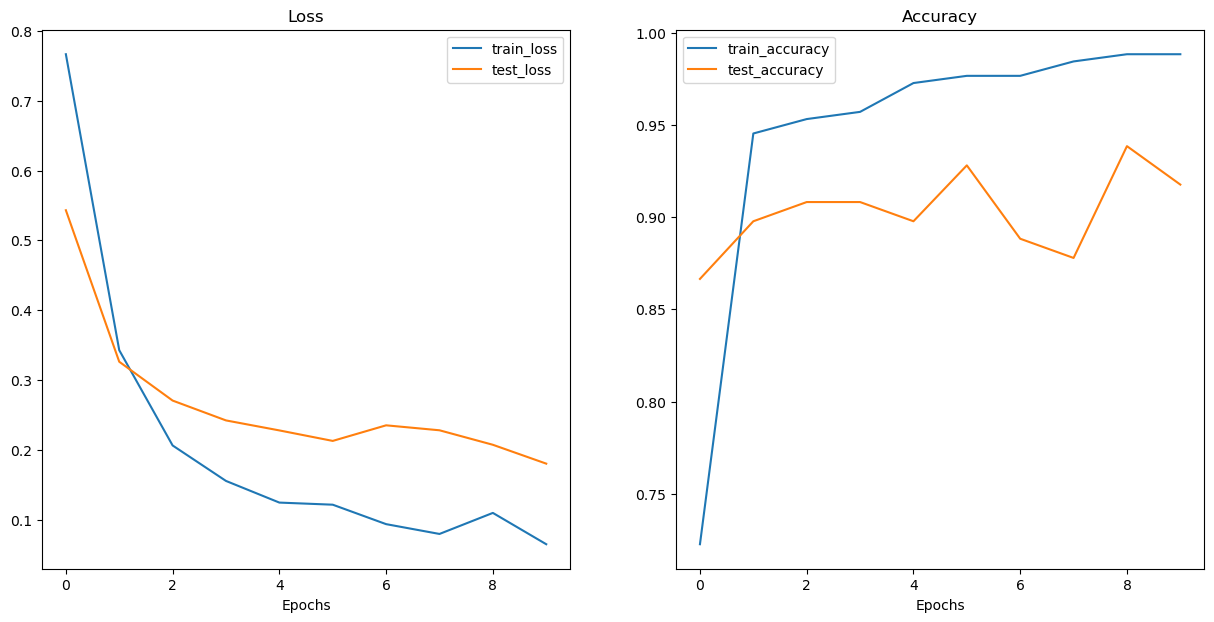

In [74]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [75]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [76]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


/Users/sallyw/machine-learning-lab/mlztm/env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


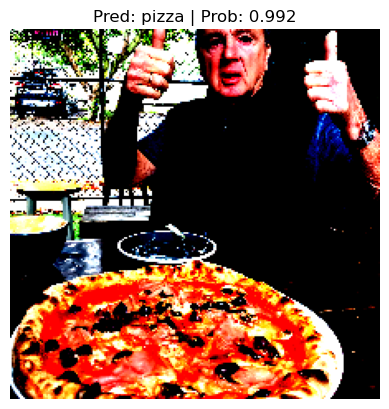

In [81]:
# predict on custom data
import requests

# Import function to make predictions on images and plot them
from helper_functions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path + "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    transform = pretrained_vit_transforms,
                    class_names=class_names)

In [79]:
image_path

'pizza_steak_sushi'